In [36]:
!pip install multi_rake

     |████████████████████████████████| 17.6MB 426kB/s eta 0:00:01
  Stored in directory: /home/ubuntu/.cache/pip/wheels/ac/a3/fa/af23f439693a5c3da8fe0942cfc5e57656799d24e6bb8c9c31
Successfully built cld2-cffi
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import FrenchStemmer
import langdetect

In [3]:


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [4]:
dir_path =r'articles.csv'
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep=';', header=None,engine='python')
articles_df= get_files(dir_path=dir_path, filename='articles.csv')

NotADirectoryError: [Errno 20] Not a directory: 'articles.csv/articles.csv'

In [7]:
articles_df=pd.read_csv('articls.csv')

In [8]:
articles_df=articles_df.iloc[:,1].to_frame()

In [9]:
articles_df.columns=['articles']

In [10]:
articles_df.shape

(110, 1)

In [11]:
tokenize_regex = "(\w+)|(\w+(-\w+)+)"
tokenize_regex = "\w+|\w+-\w+"

french_stemmer1 = SnowballStemmer('french')
french_stemmer2 = FrenchStemmer()
stop_words_fr = stopwords.words('french')

MIN_CLEAN_TOKENS = 4

def preprocess_text(doc):
    #  lowercasing
    doc = doc.lower()

    #  remove noise/unwanted characters; this is already accomplished by tokenization process.

    ## tokenization
    tokens = regexp_tokenize(doc,tokenize_regex)

    ## post-tokenization document processing

    #   remove stopwords and one-letter words
    tokens = [tok for tok in tokens if (tok not in stop_words_fr and len(tok)>5)]

    #   stemming
    tokens = [french_stemmer1.stem(tok) if len(tok)>=7 else tok for tok in tokens]

    #   word ngrams instead of 1grams

    #   remove documents that are too short  (return [])
    if len(doc) < MIN_CLEAN_TOKENS:
        return []

    return tokens



In [12]:
articles_df['articles_'] = articles_df['articles'].map(preprocess_text)
articles_df.head()

,articles,articles_
0,«Touensa jew» (les tunisiens sont arrivés) est...,"[touens, tunisien, arriv, repris, commenc, rés..."
1,"Créé en 1951, ""Sanremo Giovani"" est un concour...","[sanremo, giovan, concour, musical, italien, c..."
2,"Après avoir chanté durant plus d'une heure, Sa...","[chanté, durant, obligé, arrêt, concert, intem..."
3,Le chanteur de rock français Dick Rivers est d...,"[chanteur, franc, rivers, décédé, mercred, ann..."
4,"Après 12 mois de problèmes de santé, Céline Di...","[problem, céline, annonc, import, compte, inst..."


In [13]:

idx = articles_df['articles_'].map(lambda doc: doc==[])
print("Number of dropped rows:", idx.sum())
articles_df.drop(labels=articles_df.index[idx], axis=0,inplace=True)
articles_df.shape

Number of dropped rows: 0


(110, 2)

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import LsiModel, LdaModel, CoherenceModel
from gensim.models.word2vec import Word2Vec
from gensim import similarities

In [15]:
dictionary = Dictionary(articles_df['articles_'].tolist())
len(dictionary)

2287

In [25]:
from six import iteritems
MIN_TOKEN_DOC_FREQ = 5

idx = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq < MIN_TOKEN_DOC_FREQ]
print("Number of rare words:", len(idx))
dictionary.filter_tokens(idx) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
len(dictionary)

Number of rare words: 2087


200

In [26]:
vocab_list = list(dictionary.token2id.keys())


In [27]:
vocab_list

['arriv',
 'aventur',
 'chanson',
 'commenc',
 'interpret',
 'messag',
 'partir',
 'premi',
 'repris',
 'réseau',
 'social',
 'tunisien',
 'accompagn',
 'affair',
 'chanteur',
 'chaque',
 'collabor',
 'concert',
 'concour',
 'cultur',
 'célebr',
 'festival',
 'groupe',
 'musical',
 'nombre',
 'plusieur',
 'prochain',
 'produir',
 'réalis',
 'tourn',
 'tunis',
 'éven',
 'durant',
 'minut',
 'mosaïqu',
 'rapport',
 'soirée',
 'décédé',
 'mercred',
 'précis',
 'annonc',
 'beaucoup',
 'compte',
 'continu',
 'intitul',
 'nouvel',
 'sortie',
 'albums',
 'américain',
 'années',
 'auteur',
 'autres',
 'derni',
 'devenu',
 'encore',
 'enfant',
 'enregistr',
 'jackson',
 'lendemain',
 'michael',
 'morceau',
 'partie',
 'projet',
 'président',
 'rappeur',
 'studio',
 'succès',
 'titres',
 'vendred',
 'arabes',
 'attaqu',
 'invité',
 'janvi',
 'officiel',
 'publiqu',
 'région',
 'artist',
 'chanteux',
 'contre',
 'gratuit',
 'nombreux',
 'organis',
 'septembr',
 'égal',
 'quatre',
 'réussi',
 'sam

In [28]:
corpus_tokenized = articles_df['articles_'].tolist()
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokenized]

In [29]:
type(corpus_bow),len(corpus_bow)

(list, 110)

In [30]:
def calcul_freq_indice(ind):
    s=0
    for i in range(0,len(corpus_bow)):
        for j in corpus_bow[i]:
            if j[0]==ind:
                s=s+j[1]
    return (s)

In [31]:
dicti={}
for i in range(len(dictionary)):
    dicti[i]=calcul_freq_indice(i)
    

dict_sorted={k: v for k, v in sorted(dicti.items(), key=lambda item: item[1],reverse=True)}
j=0
most_vocab=""
for i in dict_sorted.items():
        j=j+1
        if j<=22:
            print(vocab_list[i[0]],i[1])
            most_vocab=most_vocab+vocab_list[i[0]]+" "
        else :
            break

chanson 77
musiqu 60
concert 58
artist 58
festival 56
soirée 55
chanteux 50
électron 49
tunisien 48
nouvel 46
chanteur 41
spectacl 39
groupe 36
derni 34
musical 32
public 32
annonc 28
rappeur 27
depuis 26
programm 26
premi 24
plusieur 23


In [32]:
most_vocab

'chanson musiqu concert artist festival soirée chanteux électron tunisien nouvel chanteur spectacl groupe derni musical public annonc rappeur depuis programm premi plusieur '

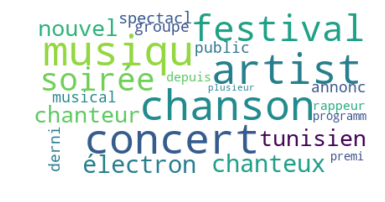

In [33]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(most_vocab)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [34]:
from rake_nltk import Rake
import operator

In [40]:
rake_object = Rake(stop_words_fr)

In [58]:
rake_object.extract_keywords_from_text(r'file.txt')

In [59]:
rake_object.get_ranked_phrases_with_scores()

[(1.0, 'txt'), (1.0, 'file')]

In [47]:
articles_df['articles'].tolist()[0]

"«Touensa jew» (les tunisiens sont arrivés) est le titre de la reprise de Bella ciao qui commence à faire le tour des réseaux sociaux.\xa0   Le message choisi par la jeune Samar Toumi,\xa0 l’interprète de la chanson est simple : encourager la sélection qui entame à partir du lundi 18 juin 2018 son aventure à la coupe du monde Russie 2018 sans oublier la touche d'humour en évoquant ses adversaires au premier tour.\xa0  \xa0   "

In [62]:
sentenceList=articles_df['articles'].tolist()
stopwordpattern = Rake.build_stop_word_regex(stoppath)
phraseList = Rake.ragenerate_candidate_keywords(sentenceList, stopwordpattern)

AttributeError: type object 'Rake' has no attribute 'build_stop_word_regex'

In [59]:
from multi_rake import Rake

rake = Rake(
    min_chars=3,
    max_words=1,
    
)

In [64]:
text=''
for ar in articles_df['articles_'].tolist():
    t=' '.join(ar)
    text=text+t

In [65]:
text

'touens tunisien arriv repris commenc réseau social messag choisi interpret chanson simple encourag sélect entame partir aventur russie oubli touche humour évoqu adversair premisanremo giovan concour musical italien chaque rivi ligure serv sélect chanteur émergent éven musical célebr italie festival canzon italian sanremo festival chanson italien mahmood vainqueur sanremo chanson accompagn nombre protagon federic abbate premi concert tourn mondial versaill pavillon gammarth prochain tunis groupe produir envol plusieur grand villes sydney buones toronto barcelon bruxel éven minister affair étranger cooper italien collabor festival sanremo réalis istituto italiano cultur tunisi ambassad italiechanté durant obligé arrêt concert intemper rapport correspond mosaïqu tabark fortes avers interrompu soirée spectateur oblig quitt gradin patient environ minutchanteur franc rivers décédé mercred anniversair suites cancer rapport célebr coiffur banane leader groupe sauvag éteint hôpital parisien pr

In [74]:
from rake_nltk import Rake
r = Rake(min_length=2, max_length=4)
keywords = r.extract_keywords_from_text(text)

In [76]:
keywords

In [84]:
r = Rake('fr') # Uses stopwords for english from NLTK, and all puntuation characters.

r.extract_keywords_from_text(text)


In [85]:
r.get_ranked_phrases() 

['touens tunisien arriv repris commenc réseau social messag choisi interpret chanson simple encourag sélect entame partir aventur russie oubli touche humour évoqu adversair premisanremo giovan concour musical italien chaque rivi ligure serv sélect chanteur émergent éven musical célebr italie festival canzon italian sanremo festival chanson italien mahmood vainqueur sanremo chanson accompagn nombre protagon federic abbate premi concert tourn mondial versaill pavillon gammarth prochain tunis groupe produir envol plusieur grand villes sydney buones toronto barcelon bruxel éven minister affair étranger cooper italien collabor festival sanremo réalis istituto italiano cultur tunisi ambassad italiechanté durant obligé arrêt concert intemper rapport correspond mosaïqu tabark fortes avers interrompu soirée spectateur oblig quitt gradin patient environ minutchanteur franc rivers décédé mercred anniversair suites cancer rapport célebr coiffur banane leader groupe sauvag éteint hôpital parisien p